# Лабораторна робота №10. Класифiкацiя текстових даних за допомогою нейромереж.

Завданням на цій лабораторній роботі є створити простий класифікатор та класифікувати дані з набору imdb та оцінити його роботу.

### Імпорт бібліотек.

In [6]:
import numpy as np
import pandas as pd

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix, accuracy_score

### Завантаження даних.
Запустіть цю клітинку, щоб завантажити дані. У цій лабораторній буде використано весь набір бази даних imdb, або 25000 записів.

In [7]:
from datasets import load_dataset

imdb = load_dataset("imdb") 
imdb = imdb['train']

/home/angst/DataInstrumentsPY/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Створіть датафрейм з словника 'imdb'.

In [4]:
df = pd.DataFrame(imdb)
df.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


### Проведіть попередню обробку даних.
Необхідно видалити всі небуквенні символи з набору даних, перевести всі символи у нижній регістр, провести стематизацію слів та видалити стоп слова з відгуків.

In [5]:
nltk.download('stopwords')
stopwords.words('english')[0: 20]

corpus = []
labels = []

all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
for i in range(0, 25000):
    review = re.sub('[^a-zA-Z]', ' ', df['text'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(all_stopwords)]

    if len(review) == 0:
        continue
    
    corpus.append(' '.join(review, ))
    labels.append(df['label'][i])
    

[nltk_data] Downloading package stopwords to /home/angst/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
corpus

['rent curiou yellow video store controversi surround first releas also heard first seiz u custom ever tri enter countri therefor fan film consid controversi realli see br br plot center around young swedish drama student name lena want learn everyth life particular want focu attent make sort documentari averag swede thought certain polit issu vietnam war race issu unit state ask politician ordinari denizen stockholm opinion polit sex drama teacher classmat marri men br br kill curiou yellow year ago consid pornograph realli sex nuditi scene far even not shot like cheapli made porno countrymen mind find shock realiti sex nuditi major stapl swedish cinema even ingmar bergman arguabl answer good old boy john ford sex scene film br br commend filmmak fact sex shown film shown artist purpos rather shock peopl make money shown pornograph theater america curiou yellow good film anyon want studi meat potato pun intend swedish cinema realli film much plot',
 'curiou yellow risibl pretenti stea

['rent curiou yellow video store controversi surround first releas also heard first seiz u custom ever tri enter countri therefor fan film consid controversi realli see br br plot center around young swedish drama student name lena want learn everyth life particular want focu attent make sort documentari averag swede thought certain polit issu vietnam war race issu unit state ask politician ordinari denizen stockholm opinion polit sex drama teacher classmat marri men br br kill curiou yellow year ago consid pornograph realli sex nuditi scene far even not shot like cheapli made porno countrymen mind find shock realiti sex nuditi major stapl swedish cinema even ingmar bergman arguabl answer good old boy john ford sex scene film br br commend filmmak fact sex shown film shown artist purpos rather shock peopl make money shown pornograph theater america curiou yellow good film anyon want studi meat potato pun intend swedish cinema realli film much plot', 'curiou yellow risibl pretenti steam

### Створіть модель Bag of Words.

In [75]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(corpus).toarray()
y = np.array(labels)

### Розділ моделі на тренувальні та тестові дані.

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

### Створіть та натренуйте класифікатор.

In [17]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

### Протестуйте роботу моделі на тестових даних.

In [18]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 1]
 [0 0]
 [1 1]
 ...
 [0 0]
 [0 0]
 [0 0]]


### Оцініть роботу моделі використовуючи матрицю конфузії.

In [19]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[2135  361]
 [ 916 1588]]


0.7446

[[2133  363]
 [ 913 1591]]


0.7448

### Створіть свою рекурентну/LSTM мережу, яка здатна класифікувати текст.

In [85]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset,TensorDataset
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


<Figure size 1000x500 with 0 Axes>

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f' {device}')

 cuda


In [87]:
df = pd.read_csv('amazon_reviews.csv')
df.head(10)

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0
5,positive,overall love this mouse the size weight clicki...,68,3.0
6,neutral,it stopped working,3,1.0
7,positive,my son uses school issued chromebook for schoo...,170,1.0
8,negative,loved this cute little mouse but it broke afte...,17,1.0
9,negative,should ve spent the money to get quality produ...,17,1.0


In [88]:
print(df.isna().sum())

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64


In [89]:
df = df.dropna()

In [90]:
print(df.isna().sum())

sentiments               0
cleaned_review           0
cleaned_review_length    0
review_score             0
dtype: int64


In [91]:
def text_preprocessing(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    tokens = word_tokenize(text.lower())  
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]  
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

In [92]:
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /home/angst/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/angst/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [93]:
df.loc[:, 'cleaned_review'] = df['cleaned_review'].apply(text_preprocessing)

In [94]:
df['cleaned_review'].head(10)

0    wish would gotten one earlier love make workin...
1    learned lesson open package use product right ...
2                          slow lag find better option
3    roller ball stopped working within month minim...
4        like color size day return period hold charge
5    overall love mouse size weight clicking fabulo...
6                                      stopped working
7    son us school issued chromebook school work ha...
8    loved cute little mouse broke month wheel brok...
9    spent money get quality product thing stopped ...
Name: cleaned_review, dtype: object

In [95]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_review'])
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])

In [96]:
max_len = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len)
labels = pd.get_dummies(df['sentiments']).values

In [97]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [98]:
train_data = TensorDataset(torch.from_numpy(X_train).long(), torch.from_numpy(y_train).float())
val_data = TensorDataset(torch.from_numpy(X_val).long(), torch.from_numpy(y_val).float())
train_loader = DataLoader(train_data, shuffle=True, batch_size=50)
val_loader = DataLoader(val_data, shuffle=True, batch_size=50)

In [99]:
class RNN(nn.Module):
    def __init__(self, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(RNN, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(len(tokenizer.word_index)+1, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x):
        embedded = self.embedding(x)
        out, hidden = self.rnn(embedded)
        out = self.dropout(out)
        out = self.fc(out[:, -1])
        return out

In [100]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size, n_layers, drop_prob=0.5):
        super(LSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out[:, -1])
        out = self.fc(lstm_out)
        return out

In [101]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [102]:
epochs = 20
output_size = 3
embedding_dim = 400
hidden_dim = 256
n_layers = 2
vocab_size = len(tokenizer.word_index) + 1

rnn_model = RNN(output_size, embedding_dim, hidden_dim, n_layers).to(device)
lstm_model = LSTM(vocab_size, embedding_dim, hidden_dim, output_size, n_layers).to(device)

In [103]:
print(rnn_model)
print(lstm_model)

RNN(
  (embedding): Embedding(8507, 400)
  (rnn): RNN(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)
LSTM(
  (embedding): Embedding(8507, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


In [104]:
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

In [105]:
def train_and_validate(model, optimizer, criterion, train_loader, val_loader, epochs, device):
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs):
        # Training mode
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, torch.max(labels, 1)[1])
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation mode
        model.eval()
        total_val_loss, total_acc = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                output = model(inputs)
                val_loss = criterion(output, torch.max(labels, 1)[1])
                total_val_loss += val_loss.item()
                acc = accuracy(output, torch.max(labels, 1)[1])
                total_acc += acc.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        avg_acc = total_acc / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accs.append(avg_acc)

        print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, Val Acc: {avg_acc}')

    return train_losses, val_losses, val_accs

In [106]:
print("RNN: \n")
rnn_train_losses, rnn_val_losses, rnn_val_accs = train_and_validate(rnn_model, rnn_optimizer, criterion, train_loader, val_loader, epochs, device)


RNN: 

Epoch: 1/20, Train Loss: 0.6954096620031398, Val Loss: 0.5855149894952774, Val Acc: 0.7758412667683192
Epoch: 2/20, Train Loss: 0.6534203104406809, Val Loss: 0.5762429871729442, Val Acc: 0.778317460843495
Epoch: 3/20, Train Loss: 0.5525286004697676, Val Loss: 0.5923721390111106, Val Acc: 0.7653333297797612
Epoch: 4/20, Train Loss: 0.4476391179420108, Val Loss: 0.5377442636660167, Val Acc: 0.7879047581127712
Epoch: 5/20, Train Loss: 0.40099219843852435, Val Loss: 0.4856745856148856, Val Acc: 0.8281904739992959
Epoch: 6/20, Train Loss: 0.3645134103491152, Val Loss: 0.4909011142594474, Val Acc: 0.8346984071390969
Epoch: 7/20, Train Loss: 0.27630871475386104, Val Loss: 0.4715894852365766, Val Acc: 0.8516825318336487
Epoch: 8/20, Train Loss: 0.20781238024665727, Val Loss: 0.4627417479242597, Val Acc: 0.8504126923424857
Epoch: 9/20, Train Loss: 0.21192616697320407, Val Loss: 0.47217651839767183, Val Acc: 0.8527619004249573
Epoch: 10/20, Train Loss: 0.1534353888881721, Val Loss: 0.5151

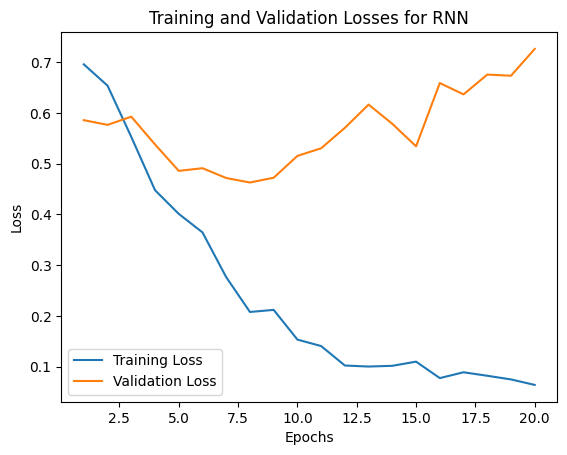

In [107]:
plt.plot(range(1, epochs + 1), rnn_train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), rnn_val_losses, label='Validation Loss')
plt.title(f'Training and Validation Losses for RNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [108]:
print("LSTM: \n")
lstm_train_losses, lstm_val_losses, lstm_val_accs = train_and_validate(lstm_model, lstm_optimizer, criterion, train_loader, val_loader, epochs, device)

LSTM: 

Epoch: 1/20, Train Loss: 0.5712065625962593, Val Loss: 0.47124608201639995, Val Acc: 0.8089523758207049
Epoch: 2/20, Train Loss: 0.3651980173995169, Val Loss: 0.3860059569988932, Val Acc: 0.8506666609219142
Epoch: 3/20, Train Loss: 0.22371592323074665, Val Loss: 0.39889548452837126, Val Acc: 0.8638412654399872
Epoch: 4/20, Train Loss: 0.13342232240377355, Val Loss: 0.39920132021818844, Val Acc: 0.8773333285536085
Epoch: 5/20, Train Loss: 0.09014793367480202, Val Loss: 0.4467732814805848, Val Acc: 0.87926983663014
Epoch: 6/20, Train Loss: 0.06056786833327639, Val Loss: 0.48413508449281967, Val Acc: 0.8784761863095419
Epoch: 7/20, Train Loss: 0.05144331122751904, Val Loss: 0.5192813605070115, Val Acc: 0.8786349168845585
Epoch: 8/20, Train Loss: 0.03693684574598514, Val Loss: 0.6626201403460332, Val Acc: 0.8751428518976484
Epoch: 9/20, Train Loss: 0.029574251478276612, Val Loss: 0.6181200856609004, Val Acc: 0.8809841224125453
Epoch: 10/20, Train Loss: 0.031715641809098104, Val Los

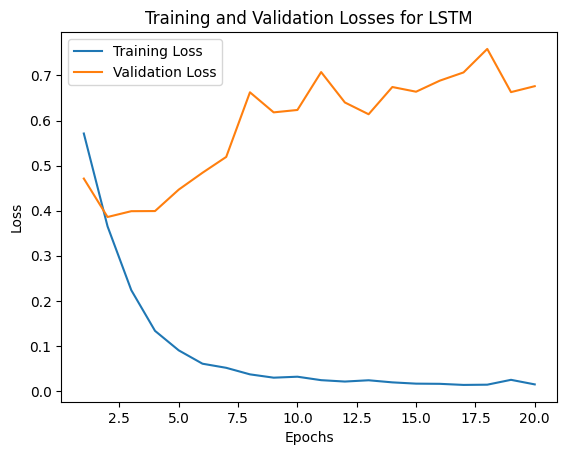

In [109]:
plt.plot(range(1, epochs + 1), lstm_train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), lstm_val_losses, label='Validation Loss')
plt.title(f'Training and Validation Losses for LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [113]:
def predict_sentiment(model, review, tokenizer, max_len):
    model.eval()
    review = text_preprocessing(review)
    sequence = tokenizer.texts_to_sequences([review])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    input_tensor = torch.from_numpy(padded_sequence).long().to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
    
    return predicted.item()\
    
review = "I love it."
predicted_sentiment = predict_sentiment(lstm_model, review, tokenizer, max_len)
if predicted_sentiment == 0:
    print("Negative")
elif predicted_sentiment == 1:
    print("Neutral")
else:
    print("Positive")


Positive
